[[0.0, 5.0, 0.7184083726671007, 0.3442900578180949, 0.8570584721035428, 0.9381376107533773, 0.88813186], [10.0, 15.0, 0.6294422679477267, 0.37952276070912677, 0.7187494171990289, 0.5164111057917277, 0.6984487], [47.0, 52.0, 0.39300526512993705, 0.5275818109512329, 0.7672327359517416, 0.9103843371073405, 0.66762614]]


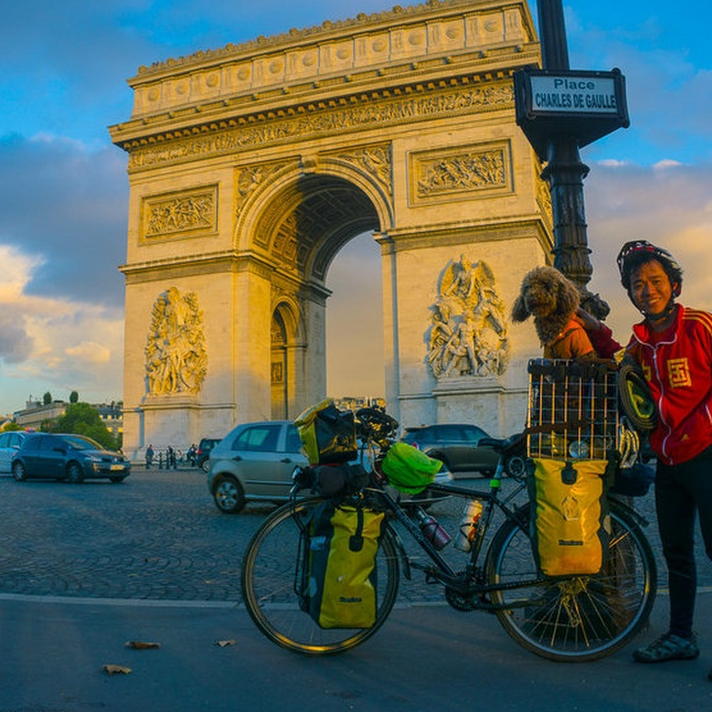

In [8]:
# Let's create a more complex example with multiple noun chunks and then visualize the image with bounding boxes.
from PIL import Image
import requests
from io import BytesIO




def crop_to_center(image):
    width, height = image.size
    new_size = 712
    left = (width - new_size)/2
    top = (height - new_size)/2
    right = (width + new_size)/2
    bottom = (height + new_size)/2
    return image.crop((left, top, right, bottom))



img_path = "/root/bigdisk/project_structured_prompt/stage_2_gligen_train/grit_files/00045/000459971.jpg"
json_path = img_path.replace(".jpg", ".json")
import json
img = Image.open(img_path).convert("RGB")
data = json.load(open(json_path, "r", encoding="utf-8"))


cropped_img = crop_to_center(img)
noun_chunks = data["noun_chunks"]
caption = data["caption"]

print(noun_chunks)

cropped_img
#noun_chunks, caption
# Note: Visualization with bounding boxes will follow next.


<|608|><|236|><|712|><|692|>A man and <|505|><|263|><|608|><|369|>a dog: Traveling around the world on <|233|><|377|><|664|><|671|>cycle


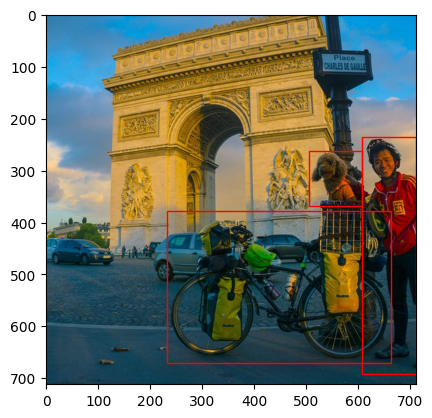

In [13]:

def adjust_bounding_box_and_caption_complex(noun_chunks, caption, original_width, original_height, crop_width=712, crop_height=712):
    """
    Adjusts bounding boxes based on the original image size and modifies the caption to include positional info.
    
    Parameters:
    - noun_chunks: List of tuples with noun chunk information.
    - caption: Original caption string.
    - original_width: Width of the original image before cropping.
    - original_height: Height of the original image before cropping.
    - crop_width: Width of the cropped image.
    - crop_height: Height of the cropped image.
    
    Returns:
    - Modified caption with positional info added.
    """
    # Calculate crop offsets if the image was centered before cropping
    offset_x = (original_width - crop_width) / 2 if original_width > crop_width else 0
    offset_y = (original_height - crop_height) / 2 if original_height > crop_height else 0
    
    # Sort noun_chunks by start position in reverse to not mess up the indexes when modifying the string
    noun_chunks = sorted(noun_chunks, key=lambda x: x[0], reverse=True)
    
    for chunk in noun_chunks:
        # Un-normalize bounding box coordinates to the original image size
        x_min = (chunk[2] * original_width) - offset_x
        y_min = (chunk[3] * original_height) - offset_y
        x_max = (chunk[4] * original_width) - offset_x
        y_max = (chunk[5] * original_height) - offset_y
        
        # Ensure the coordinates are within the cropped image bounds
        x_min = max(0, min(x_min, crop_width))
        y_min = max(0, min(y_min, crop_height))
        x_max = max(0, min(x_max, crop_width))
        y_max = max(0, min(y_max, crop_height))
        
        # Insert the positional info at the noun it is referring to
        position_info = f"<|{x_min:.0f}|><|{y_min:.0f}|><|{x_max:.0f}|><|{y_max:.0f}|>"
        start, end = int(chunk[0]), int(chunk[1])
        caption = caption[:start] + position_info + caption[start:]
    
    return caption


# Adjust the caption with specific noun chunk position info
new_caption_complex = adjust_bounding_box_and_caption_complex(noun_chunks, caption, img.width, img.height)
print(new_caption_complex)

# Visualization function for image and bounding boxes
import re
def visualize_with_bounding_boxes(image, caption_structure):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # extract noun chunks from caption_structure
    # capture <|(x_min)|><|(y_min)|><|(x_max)|><|(y_max)|>
    noun_chunks = re.findall(r"<\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\>", caption_structure)
    noun_chunks = [(int(x_min), int(y_min), int(x_max), int(y_max)) for x_min, y_min, x_max, y_max in noun_chunks]
    
    
    # Plot bounding boxes
    for chunk in noun_chunks:
        # Un-normalize bounding box coordinates
        # x_min = chunk[0] * image.width
        # y_min = chunk[1] * image.height
        # width = (chunk[4] - chunk[2]) * image.width
        # height = (chunk[5] - chunk[3]) * image.height
        x_min, y_min, x_max, y_max = chunk
        width, height = x_max - x_min, y_max - y_min
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

visualize_with_bounding_boxes(cropped_img, new_caption_complex)
